# Vive Pro Eye Evaluation - Spatial and Individual Data Quality, IPD Figures

This notebook reproduces the following figures from the manuscript: 

- Figure 4: Average gaze position + confidence ellipses for all targets
- Figure 5: Individual accuracy / precision for each participant and session
- Figure 7: Accuracy across the FOV, split by vision correction and HMD
- Figure 8: Actual and predicted inter-pupillary distance (IPD), with regression results

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import linregress

from analysis import * 

from palettable.colorbrewer.qualitative import Set1_9, Paired_11, Set2_8, Set3_9
from palettable.tableau import Tableau_20, Tableau_10, TableauLight_10
PPID_COLORS = np.vstack([Tableau_10.mpl_colors, TableauLight_10.mpl_colors])

FLOAT_FMT = '%.2f'
FIGTYPES = ['png']

# Vision correction icons for Fig. 5
# Icons designed by OpenMoji, https://openmoji.org. License: CC-BY-SA 4.0
emoji_eye = plt.imread('icons/1F441.png')
emoji_glasses = plt.imread('icons/1F453.png')


Note: vexptoolbox is not running under Vizard, or Vizard packages could not be imported. Only analysis tools will be available.


In [2]:
# Folders
folder_pkl = '.'
folder_results = '../results'

# Load preprocessed data
(tar, tar_i10, val, pp, sam) = load_pickle_data(folder_pkl)


Data loaded from pickles.


## Figure 4: Accuracy Across the Field of View (FOV)

In [3]:
def paper_figure_average_gaze_column(tar, figsize=(3.25, 6.5), ellipse=True, ellipse_sd=2, clim=(0.0, 2.0)):
    """ Scatter plot: average gaze endpoints during validation for each target position """
    
    LABEL_SIZE = 12
    TICK_SIZE = 10
    ELLIPSE_WIDTH = 1.2
    TAR_SIZE = 8 # roughly 1 deg across
    TAR_WIDTH = 1.0
    TICKS = [-15, -10, -5, 0, 5, 10, 15]
    MARKER_SIZE = 4
    MARKER_ALPHA = 0.3

    fig = plt.figure(figsize=figsize, dpi=150)
    axs = {}
    c = 1
    cmap = plt.get_cmap('viridis')
    
    depths = sorted(tar.d.unique(), reverse=True)
    for d in depths:
        tarD = tar.loc[tar.d == d, :]
        cnorm = Normalize(vmin=clim[0], vmax=clim[1])
        cs = ScalarMappable(norm=cnorm, cmap='viridis')

        ax = fig.add_subplot(len(depths), 1, c)
        
        # Plot data separately per target, so we can apply colors and confidence ellipses
        tarpos = tarD.groupby(['x', 'y']).size().reset_index().iloc[:, 0:2].values
        for tp in tarpos:
            tarDP = tarD.loc[(tarD.x == tp[0]) & (tarD.y == tp[1])]
            color = cs.to_rgba(tarDP.acc.mean())
            ax.plot(tarDP.avgX, tarDP.avgY, '.', color=color, markersize=MARKER_SIZE, alpha=MARKER_ALPHA, markeredgewidth=0)
            ax.plot(tp[0], tp[1], 'k+', markersize=TAR_SIZE, markeredgewidth=TAR_WIDTH, zorder=4)
                        
            if ellipse:
                # Calculate confidence ellipse
                confidence_ellipse(tarDP.avgX, tarDP.avgY, ax, edgecolor=color, n_std=ellipse_sd, linewidth=ELLIPSE_WIDTH, zorder=3)

        ax.set_ylabel('Vertical Position (°)', fontsize=LABEL_SIZE)
        #ax.set_title('Distance {:.1f} m'.format(d), fontsize=LABEL_SIZE)
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        ax.set_xticks(TICKS)
        ax.set_xticklabels(TICKS, fontsize=TICK_SIZE)
        ax.tick_params(labelsize=TICK_SIZE, direction='in', width=1.0, length=4)
        
        if c == 1:
            ax.set_xlabel('')
            ax.set_xticks([])

        elif c == 2:
            ax.set_xlabel('Horizontal Position (°)', fontsize=LABEL_SIZE)
            ax.set_yticks(TICKS)
            ax.set_yticklabels(TICKS, fontsize=TICK_SIZE)

        # Add colorbar to axis, c.f.
        # https://stackoverflow.com/questions/32462881/add-colorbar-to-existing-axis
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.07)
        cb = plt.colorbar(ScalarMappable(norm=Normalize(vmin=clim[0], vmax=clim[1]), cmap=plt.get_cmap('viridis')),
                     cax=cax,
                     orientation='vertical')
        
        cax.tick_params(labelsize=TICK_SIZE, direction='in', width=1.0, length=4)
        cax.set_ylabel('Mean Gaze Error (°), {:.1f} m'.format(d), fontsize=TICK_SIZE)
        cb.outline.set_linewidth(1.2)
        cb.outline.set_edgecolor('k')

            
        MARGIN = 3
        ax.set_xlim([tar.x.min() - MARGIN, tar.x.max() + MARGIN])
        ax.set_ylim([tar.x.min() - MARGIN, tar.y.max() + MARGIN])
        c += 1
        
        for axis in ['bottom','left', 'top','right']:
            ax.spines[axis].set_linewidth(1.2)
            ax.spines[axis].set_color('k')
            ax.spines[axis].set_zorder(10)
        
    fig.tight_layout()
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05)
        


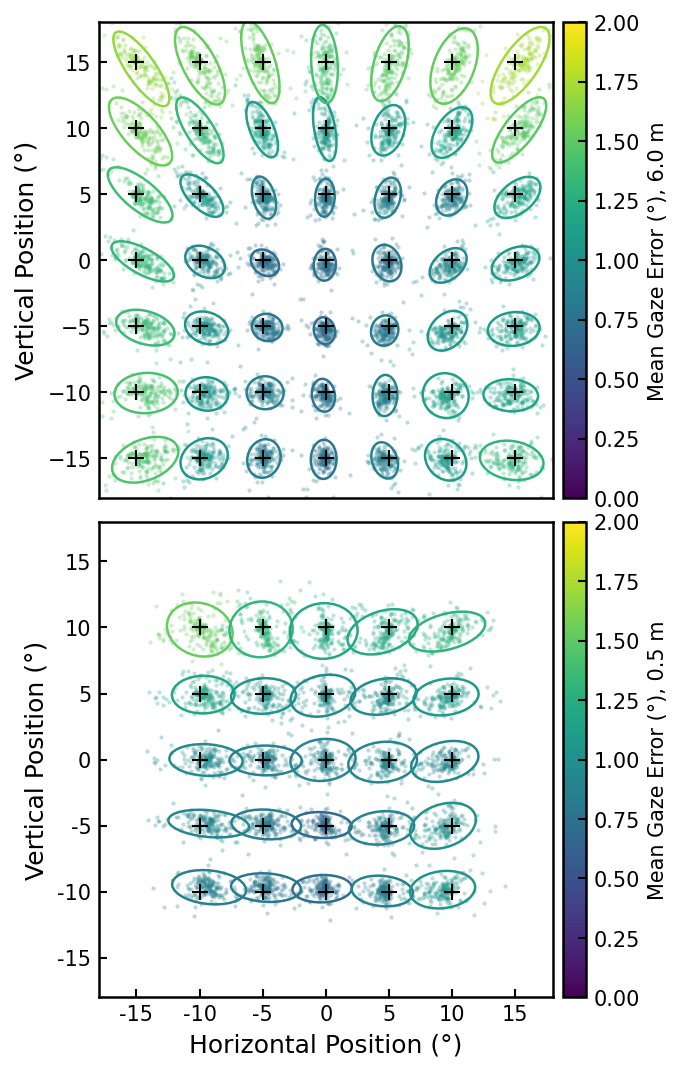

In [4]:
# Figure 4: Average gaze position per target and confidence ellipses
paper_figure_average_gaze_column(tar, clim=(0, 2.0))

for fmt in FIGTYPES:
    plt.savefig(os.path.join(folder_results, 'figure4.{:s}'.format(fmt)), bbox_inches='tight', dpi=300)
    
# Save 900dpi TIFF as requested by journal
plt.savefig(os.path.join(folder_results, 'figure-04.tif'), bbox_inches='tight', dpi=900)


## Figure 5: Individual participant accuracy and precision

In [5]:
def paper_figure_individual_acc_column(val, uids=None, figsize=(3.5, 3.0), dodge=0.6, ylim=[0, 4], acc_var='acc', prec_var='sd'):

    LABEL_SIZE = 11
    TICK_SIZE = 9
    SUB_MARKER_SIZE = 3
    MARKER_SIZE = 5
    ERRBAR_WIDTH = 1.0
    EMOJI_OFFSX = 0.17
        
    if uids == None:
        uids = list(val.loc[:, ('uid', acc_var)].groupby(['uid']).mean().sort_values([acc_var]).reset_index().loc[:, 'uid'].values)
        users = list(val.loc[:, ('uid', acc_var, 'user')].groupby(['uid', 'user']).mean().sort_values([acc_var]).reset_index().loc[:, 'user'].values)

    # Accuracy
    fig = plt.figure(figsize=figsize, dpi=150)
    ax1 = fig.add_subplot(211)
    acc = []
    for idx, uid in enumerate(uids):
        
        user = int(users[idx])-1
        m = val.loc[val.uid == uid, acc_var].values
        
        marker = 'o'
        
        acc.append(m)
        ax1.plot(np.repeat(idx+1, len(m)) + dodge * (np.random.random((len(m), 1)) - 0.5), m,
                 'o', markersize=SUB_MARKER_SIZE, alpha=0.1, markerfacecolor=PPID_COLORS[user], 
                 markeredgecolor='k', markeredgewidth=0)
        sem = np.nanstd(m) / np.sqrt(m.shape[0])
        std = np.nanstd(m)
        ax1.errorbar(x=idx+1, y=np.nanmean(m), yerr=std, marker=marker, markersize=MARKER_SIZE, ecolor='k',
                     alpha=1.0, color=PPID_COLORS[user], linewidth=ERRBAR_WIDTH, markeredgecolor='k', zorder=4)
        ax1.plot(idx+1, np.nanmedian(m), marker='.', markersize=SUB_MARKER_SIZE, color='k', zorder=5)

        if np.any(val.loc[val.uid == uid, 'vision'].values == 'glasses'):
            imagebox = OffsetImage(emoji_glasses, zoom=0.15, interpolation='lanczos')
            ab = AnnotationBbox(imagebox, (idx+1, ylim[0] + EMOJI_OFFSX), frameon = False)
            ax1.add_artist(ab)
            
        elif np.any(val.loc[val.uid == uid, 'vision'].values == 'contacts'):
            imagebox = OffsetImage(emoji_eye, zoom=0.1, interpolation='lanczos')
            ab = AnnotationBbox(imagebox, (idx+1, ylim[0] + EMOJI_OFFSX), frameon = False)
            ax1.add_artist(ab)

    ax1.set_ylabel('Mean Gaze Error (°)', fontsize=LABEL_SIZE)
    ax1.set_xlabel('')
    ax1.set_ylim(ylim)
    
    # Precision
    ax2 = fig.add_subplot(212)
    prec = []
    for idx, uid in enumerate(uids):

        user = int(users[idx])-1
        m = val.loc[val.uid == uid, prec_var].values
        prec.append(m)
        ax2.plot(np.repeat(idx+1, len(m)) + dodge * (np.random.random((len(m), 1)) - 0.5), m, 
                 'o', markersize=SUB_MARKER_SIZE, alpha=0.1, markerfacecolor=PPID_COLORS[user], 
                 markeredgecolor='k', markeredgewidth=0)
        sem = np.nanstd(m) / np.sqrt(m.shape[0])
        std = np.nanstd(m)
        ax2.errorbar(x=idx+1, y=np.nanmean(m), yerr=std, marker='o', markersize=MARKER_SIZE, ecolor='k',
                     alpha=1.0, color=PPID_COLORS[user], linewidth=ERRBAR_WIDTH, markeredgecolor='k', zorder=4)
        ax2.plot(idx+1, np.nanmedian(m), marker='.', markersize=SUB_MARKER_SIZE, color='k', zorder=5)

    ax2.set_xlabel('Participant #', fontsize=LABEL_SIZE)
    ax2.set_ylabel('Gaze Error SD (°)', fontsize=LABEL_SIZE)
    ax2.set_ylim(ylim)

    for axx in [ax1, ax2]:
        axx.xaxis.grid(False)
        axx.yaxis.grid('major', lw=0.4)
        axx.set_xticks(np.arange(1, len(uids)+1))
        for axis in ['bottom','left','top','right']:
            axx.spines[axis].set_linewidth(1.2)
            axx.spines[axis].set_color('k')
        for axis in ['top','right']:
            axx.spines[axis].set_linewidth(0)
        axx.set_xticklabels(users, fontsize=TICK_SIZE)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2)


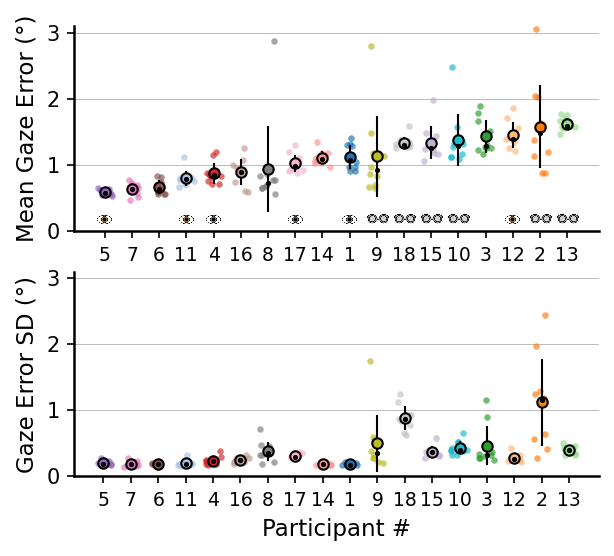

In [6]:
# Figure 5: Invidiual accuracy and precision
paper_figure_individual_acc_column(val, acc_var='acc_valid', prec_var='sd_valid', ylim=(0, 3.1))

for fmt in FIGTYPES:
    plt.savefig(os.path.join(folder_results, 'figure5.{:s}'.format(fmt)), bbox_inches='tight', dpi=300)

# Save 900dpi TIFF as requested by journal
plt.savefig(os.path.join(folder_results, 'figure-05.tif'), bbox_inches='tight', dpi=900)

## Figure 7: Accuracy across the FOV, split by vision correction and HMD

In [7]:
def paper_figure_average_vision_hmd(model_mat, measure='acc', figsize=(6.875, 3.0), clim=None, clabel='Mean Error (°)'):

    TICK_SIZE = 6
    LABEL_SIZE = 8
    VALUE_SIZE = 5
    TITLES = ['No Correction', 'Contacts', 'Glasses']
    
    fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=150)
    axs = {}

    for r in range(0, len(model_mat)):
        rmat = model_mat[r]
        for c, mat in enumerate(rmat):
            
            xval = np.arange(mat['_x'][0], mat['_x'][1]+mat['_g'], mat['_g'])
            yval = np.arange(mat['_y'][0], mat['_y'][1]+mat['_g'], mat['_g'])
            a = mat[measure][6.0]

            ax[0][c].set_title(TITLES[c], fontsize=LABEL_SIZE)
            im = ax[r][c].imshow(a, cmap=plt.get_cmap('viridis'))
            if clim is not None:
                im.set_clim(clim)

            if c == 0:
                ax[r][c].set_ylabel('Vertical Position (°)', fontsize=LABEL_SIZE)
                ax[r][c].set_yticks(np.arange(0, a.shape[1]))
                ax[r][c].set_yticklabels(['{:-.0f}'.format(-v) for v in yval], fontsize=TICK_SIZE)
            else:
                ax[r][c].set_yticks([])

            if c == 1 and r == 1:
                ax[r][c].set_xlabel('Horizontal Position (°)', fontsize=LABEL_SIZE)
            if r == 1:
                ax[r][c].set_xticks(np.arange(0, a.shape[1]))
                ax[r][c].set_xticklabels(['{:-.0f}'.format(v) for v in xval], fontsize=TICK_SIZE)
                ax[r][c].tick_params(labelsize=TICK_SIZE)
            elif r== 0:
                ax[r][c].set_xticks([])
            
            # Add colorbar to axis, c.f.
            # https://stackoverflow.com/questions/32462881/add-colorbar-to-existing-axis
            divider = make_axes_locatable(ax[r][c])
            cax = divider.append_axes('right', size='5%', pad=0.07)
            if c == 2:
                if clim is not None:
                    cb = plt.colorbar(ScalarMappable(norm=Normalize(vmin=clim[0], vmax=clim[1]), cmap=plt.get_cmap('viridis')),
                                      cax=cax,
                                      orientation='vertical')
                else:
                    cb = plt.colorbar(ScalarMappable(cmap=plt.get_cmap('viridis')),
                                      cax=cax,
                                      orientation='vertical')
                cax.tick_params(labelsize=TICK_SIZE)
                cax.set_ylabel(clabel + ', HMD {:d}'.format(r+1), fontsize=TICK_SIZE)
                cb.outline.set_linewidth(1.2)
                cb.outline.set_edgecolor('k')
            else:
                cax.axis('off')

            for x in range(0, a.shape[1]):
                for y in range(0, a.shape[0]):
                    if a[y, x] > 0:
                        ax[r][c].text(x, y, '{:.2f}'.format(a[y, x]), ha='center', va='center', color='k', fontsize=VALUE_SIZE)

            for axis in ['bottom','left', 'top','right']:
                ax[r][c].spines[axis].set_linewidth(1.2)
                ax[r][c].spines[axis].set_color('k')
                ax[r][c].spines[axis].set_zorder(10)

        plt.tight_layout()
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=-0.59, hspace=0.07)



C:\Users\Immo\AppData\Roaming\Python\Python37\site-packages\numpy\lib\shape_base.py:379: RuntimeWarning: Mean of empty slice
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
C:\Users\Immo\AppData\Roaming\Python\Python37\site-packages\numpy\lib\shape_base.py:402: RuntimeWarning: Mean of empty slice
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


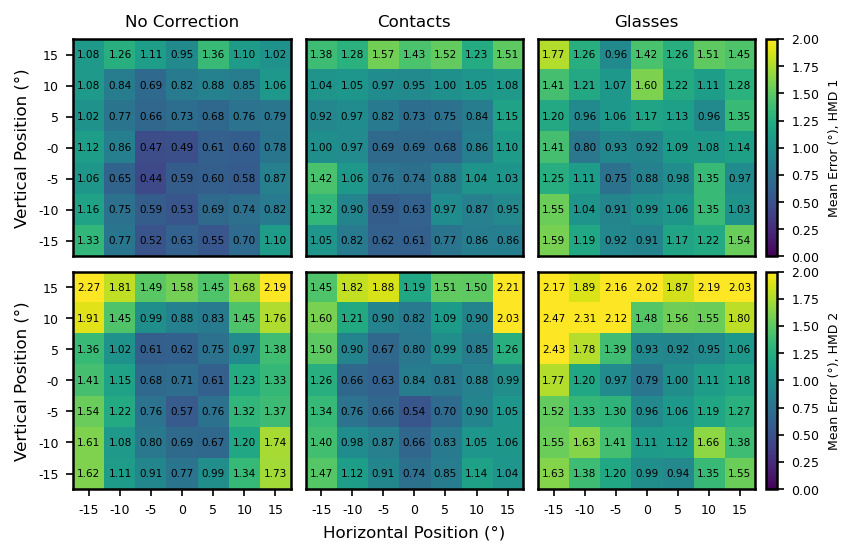

In [8]:
# Select target fixation data separately by vision correction and HMD
nocorr = [[], []]
contacts = [[], []]
glasses = [[], []]

for row in val.iterrows():
    vid = row[1].val_id
    mat = fill_target_matrix(tar.loc[tar.val_id == vid, :])
    if row[1].vision == 'uncorrected':
        nocorr[int(row[1].hmd)-1].append(mat)
    elif row[1].vision == 'contacts':
        contacts[int(row[1].hmd)-1].append(mat)
    elif row[1].vision == 'glasses':
        glasses[int(row[1].hmd)-1].append(mat)

# Aggregate into an average accuracy matrix for each factor combination
model_mat = [[aggregate_target_matrix(nocorr[0], fun=np.nanmean), aggregate_target_matrix(contacts[0], fun=np.nanmean), aggregate_target_matrix(glasses[0], fun=np.nanmean)],
             [aggregate_target_matrix(nocorr[1], fun=np.nanmean), aggregate_target_matrix(contacts[1], fun=np.nanmean), aggregate_target_matrix(glasses[1], fun=np.nanmean)]]

# Plot
paper_figure_average_vision_hmd(model_mat, clim=(0, 2))
for fmt in FIGTYPES:
    plt.savefig(os.path.join(folder_results, 'figure7.{:s}'.format(fmt)), bbox_inches='tight', dpi=300)

# Save 900dpi TIFF as requested by journal
plt.savefig(os.path.join(folder_results, 'figure-07.tif'), bbox_inches='tight', dpi=900)


## Figure 8: Inter-Pupillary Distance

In [9]:
def paper_figure_ipd(val, uids=None, figsize=(3.25, 3.25), lim=(52, 71), dodge=0.6, ipd_var='ipd_valid'):

    LABEL_SIZE = 12
    TICK_SIZE = 9
    SUB_MARKER_SIZE = 3
    MARKER_SIZE = 7
    ERRBAR_WIDTH = 1.4
    GT_WIDTH = 1.0
    MARKER = 'o'
    
    if uids == None:
        uids = list(val.loc[:, ('uid', ipd_var)].groupby(['uid']).mean().sort_values([ipd_var]).reset_index().loc[:, 'uid'].values)
        users = list(val.loc[:, ('uid', ipd_var, 'user')].groupby(['uid', 'user']).mean().sort_values([ipd_var]).reset_index().loc[:, 'user'].values)

    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=150, facecolor='w')

    avg_errs = []
    gt = []
    avg = []
    
    for idx, uid in enumerate(uids):

        # Ground-truth IPD
        m_gt = val.loc[val.uid == uid, 'IPDpp'].values
        
        # Check if IPD was measured for this participant
        if not np.all(np.isnan(m_gt)):

            # Eye-tracker measured IPD
            user = int(users[idx])-1
            m = val.loc[val.uid == uid, ipd_var].values
            sem = np.nanstd(m) / np.sqrt(m.shape[0])
            std = np.nanstd(m)

            # Individual sessions
            ax.plot(np.repeat(np.nanmean(m_gt), m.shape[0]), m, marker=MARKER, markersize=SUB_MARKER_SIZE, lw=0, markeredgewidth=0.6,
                         alpha=0.5, color=PPID_COLORS[user], zorder=3)

            # Average by participant
            err = np.abs(np.nanmean(m) - np.nanmean(m_gt))
            h, = ax.plot(np.nanmean(m_gt), np.nanmean(m), marker=MARKER, markersize=MARKER_SIZE, lw=0, markeredgewidth=GT_WIDTH, markeredgecolor='k',
                         alpha=1, color=PPID_COLORS[user], zorder=4)
            
            # alternative with SD
            #ax.errorbar(x=np.nanmean(m_gt), y=np.nanmean(m), yerr=std, marker=MARKER, markersize=MARKER_SIZE, markeredgewidth=GT_WIDTH, ecolor='k',
            #             alpha=1.0, color=PPID_COLORS[user], linewidth=ERRBAR_WIDTH, markeredgecolor='k', zorder=4)#

            # Directional error 
            ipd_err = m - np.nanmean(m_gt)
            avg_errs.append(np.nanmean(ipd_err))
            if not np.isnan(np.nanmean(m_gt)) and not np.isnan(np.nanmean(m)):
                avg.append(np.nanmean(m))
                gt.append(np.nanmean(m_gt))

    
    # Diagonal
    x = np.arange(45, 72, 0.1)
    y = np.arange(45, 72, 0.1)
    ax.fill_between(x, y - 0.5, y + 0.5, alpha=0.2, color=[0.6, 0.6, 0.6], linewidth=0, zorder=0)
    ax.plot(x, y, linestyle=(0,(1,1)), linewidth=ERRBAR_WIDTH, color=[0.3, 0.3, 0.3], label='identity $\pm$ 0.5 mm', zorder=1)
    
    # Regression line
    xr = np.arange(min(gt)-1, max(gt)+1, 0.1)
    lm = np.polyfit(gt, avg, 1)
    predict = np.poly1d(lm)
    y_hat = predict(x)
    
    # Correlation and R²
    slope, intercept, r_value, p_value, std_err = linregress(gt, avg)
    stats = 'r={:.3f} (R²={:.3f})'.format(r_value, r_value**2)
    ax.plot(x, y_hat, '-', linewidth=ERRBAR_WIDTH, color='b', label=stats)
    
    # Statistics results
    print('True IPD: mean: {:.1f}, median {:.1f}, range: {:.1f} - {:.1f}'.format(np.mean(gt), np.median(gt), np.min(gt), np.max(gt)))
    print('Estimated IPD: mean: {:.1f}, median {:.1f}, range: {:.1f} - {:.1f}'.format(np.mean(avg), np.median(avg), np.min(avg), np.max(avg)))
    print('Regression result: r={:.3f}, p={:.10f}, R²={:.3f}'.format(r_value, p_value, r_value**2))
    print('Average IPD Error: {:.3f} +/- {:.3f} mm, range {:.3f} - {:.3f} mm\n\n'.format(np.nanmean(avg_errs), np.nanstd(avg_errs), np.nanmin(avg_errs), np.nanmax(avg_errs))) 
    
    ax.tick_params(labelsize=TICK_SIZE, direction='in', width=1.0, length=4)
    ax.set_xlabel('Participant IPD (mm)', fontsize=LABEL_SIZE)
    ax.set_ylabel('Eye Tracker IPD (mm)', fontsize=LABEL_SIZE)
    ax.set_xlim(lim)
    ax.set_ylim(lim)

    leg = ax.legend(loc='upper left', 
                    fontsize=TICK_SIZE, 
                    facecolor='w', 
                    frameon=True, 
                    framealpha=1,
                    edgecolor='w', 
                    fancybox=False, 
                    title_fontsize=9)

    ax.xaxis.grid(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.2)
        ax.spines[axis].set_color('k')
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.22)
    fig.align_ylabels()


True IPD: mean: 61.1, median 60.8, range: 55.0 - 70.0
Estimated IPD: mean: 60.7, median 60.1, range: 53.8 - 70.3
Regression result: r=0.988, p=0.0000000000, R²=0.977
Average IPD Error: -0.478 +/- 0.696 mm, range -1.346 - 0.835 mm




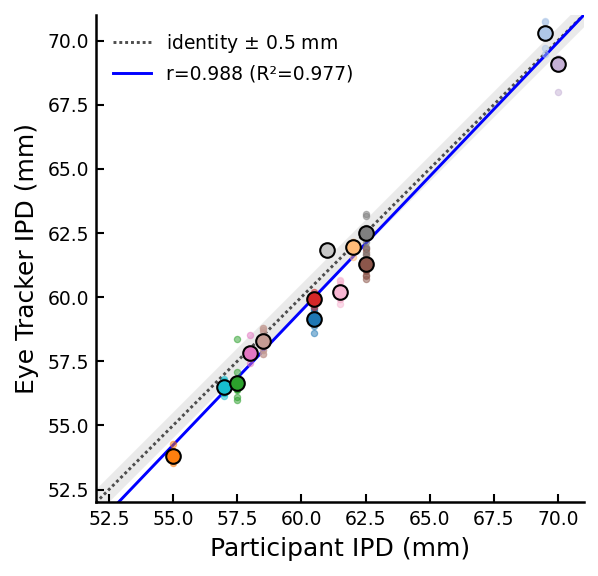

In [10]:
# Figure 8: Inter-Pupillary Distance + Regression
paper_figure_ipd(val, ipd_var='ipd_valid')

for fmt in FIGTYPES:
    plt.savefig(os.path.join(folder_results, 'figure8.{:s}'.format(fmt)), 
                bbox_inches='tight', 
                dpi=300)

# Save 900dpi TIFF as requested by journal
plt.savefig(os.path.join(folder_results, 'figure-08.tif'), bbox_inches='tight', dpi=900)
